In [1]:
import numpy as np
from robot_navigation import is_segments_intersect, check_polyline
from matplotlib import pyplot as plt

In [4]:
segment_1 = (np.array([6, 5]), np.array([7, 4])) 
segment_2 = (np.array([3, 7]), np.array([7, 7]))

is_segments_intersect(segment_1, segment_2)

False

# solution

In [5]:
import json

with open('robot_data.json', 'r') as f:
    data = json.load(f)
    
data

{'start': [0, 0],
 'finish': [10, 10],
 'obstacles': [[[2, 2], [2, 4], [3, 3]], [[5, 4], [4, 6], [6, 5], [7, 4]]]}

In [161]:
def calculateDistance(x1,y1,x2,y2):
    dist = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return dist


def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
        raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y

def get_crossed_vec(start, curr_step, obstacles):
    crossed_vec, dists = [], []
    for obs in obstacles:
        for vec1, vec2 in zip(obs, np.vstack([obs[1:], obs[0]])):
            line1 = np.array((vec1, vec2))
            crossed = is_segments_intersect(line1, (start, curr_step))
            if crossed:
                l1 = vec1 - vec2
                l2 = start - curr_step
                l1 = line_intersection((vec1, vec2), l2)
                dist = calculateDistance(x1=l1[0], y1=l1[1], x2=l2[0], y2=l2[1])
                crossed_vec.append(line1)
                dists.append(dist)
                print(crossed_vec)
    if len(crossed_vec)>0:
        print(dists)
        crossed_vec = crossed_vec[np.argmin(dists)]
        print(crossed_vec)
    return crossed_vec

def get_angle(vec1, vec2):
    norm_v1 = np.linalg.norm(vec1)
    norm_v2 = np.linalg.norm(vec2)
    cosA = np.cross(vec1, vec2)/(norm_v1*norm_v2)
    alpha = np.rad2deg(np.arccos(cosA))
    return alpha

def get_new_direction(crossed_vec, pure_vector):
    a, b = crossed_vec
#     print(a, b)
    angleAB = get_angle(pure_vector, b-a)
    angleBA = get_angle(pure_vector, a-b)
    new_dir = b-a if (angleAB<angleBA and ((b-a)>0).any()) else a-b
#     print((b-a), (b-a).any()>0)
#     print(pure_vector, a-b, b-a, new_dir)
    new_dir_normed = new_dir/np.linalg.norm(new_dir)
    return new_dir_normed

def get_next_step(finish, curr_start, obstacles):
    pure_vector = finish - curr_start
    pure_vector_normed = pure_vector/np.linalg.norm(pure_vector)
    
    next_step = curr_start+pure_vector_normed
    crossed_vec = get_crossed_vec(curr_start, next_step, obstacles)
    print(f'crossed_vec = {crossed_vec}')
    if len(crossed_vec):
        new_dir_normed = get_new_direction(crossed_vec, pure_vector)
        curr_start = curr_start+new_dir_normed
    else:
        curr_start = curr_start+pure_vector_normed
    return curr_start

In [162]:
start, finish = np.array(data['start']), np.array(data['finish'])
obstacles = data['obstacles']
obstacles = [[[1, 2], [2, 4], [4, 3], [1, 2]], 
             [[5, 4], [4, 6], [6, 5], [7, 4]],
            [[8, 8], [8, 10], [9, 9], [9, 7]]]

In [163]:
curr_start = start
my_path = [curr_start]

max_iteration = 100
while max_iteration >= 0 and (curr_start<finish).any():
    curr_start = get_next_step(finish, curr_start, obstacles)
    my_path.append(curr_start)
    max_iteration -= 1

crossed_vec = []
crossed_vec = []
crossed_vec = []


IndexError: invalid index to scalar variable.

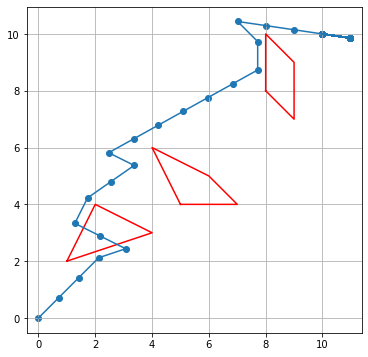

In [157]:
plt.figure(figsize=(6,6))
plt.axis('equal')

for ob in obstacles:
    ob = list(ob)
    ob.append(ob[0])
    x,y = zip(*ob)
    plt.plot(x, y, c='red')
    
x,y = zip(*my_path)
plt.scatter(x, y)
plt.plot(x,y)
plt.grid()
plt.show()

In [21]:
check_polyline(polyline=my_path, obstacles=np.array(obstacles))

True